In [79]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/users/aqib/desktop/ucsb/research/bccl/dmd_codes')
from monomials import Monomials
from monomials import Monomials_xu
import seaborn as sn
import math

# DMD with control

In [86]:
def calc_Input_Koopman(data_x_p,data_x_f,data_u):

    n,m,l = data_x_p.shape
    p = data_u.shape[0]
    
    data_x_p = data_x_p.reshape((n,m*l),order='F')
    data_x_f = data_x_p.reshape((n,m*l),order='F')
    data_u = data_u.reshape((p,m*l),order='F')

    Omega = (np.vstack((data_x_p,data_u)))
    
    K = np.dot(data_x_f,np.linalg.pinv(Omega))
    
    A = K[:,0:K.shape[0]]
    B = K[:,K.shape[0]:]
    
    return ([K,A,B]);

#  ODEs

In [99]:
global Kd, gamma, k0, k1, u

Kd = 0.5
gamma = np.random.normal(0.03,0.01)
k0 = np.random.normal(0.02,0.01)
k1 = np.random.normal(0.03,0.01)

# def iff_loop(x,t): 
    
#     Adot = k0*u - gamma*x[0] 
#     Bdot = k1*u/(1+x[0]/Kd) - gamma*x[1] 
    
#     return ([Adot,Bdot])

    

# numerically integrate the ODEs

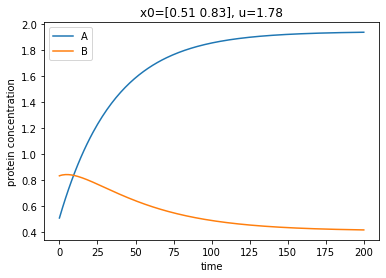

In [100]:
numStates = 2
numInputs = 1

tStart = 0.0
tEnd = 200
numTimesteps = tEnd
numTimepoints = np.int(numTimesteps)
tSpan = np.linspace(tStart,tEnd,numTimepoints)

numTrajectories = 1

uvec = []
data = np.empty(shape=[numStates,numTimepoints,0])
for traj in range(0,numTrajectories):
    
    u = np.random.uniform(10,0.01)
    uvec.append(u)
    x0 = np.random.uniform(1,0.01,numStates)
    x = odeint(iff_loop,x0,tSpan)
    x = x.T[:,:,np.newaxis]
    data = np.append(data,x,axis=2)
    
    if numTrajectories < 21:
        plt.figure();
        h = plt.plot(tSpan,data[:,:,traj].T);
        plt.legend((h[0],h[1]),('A','B'));
        plt.xlabel('time');
        plt.ylabel('protein concentration');
        plt.title('x0=' + str(np.round(x0,2)) +', ' + 'u=' + str(round(u,2)))
uvec = np.array(uvec)

## identify A and B using input Koopman formulation

In [101]:
train_start = 0
train_stop = round(0.95*numTimepoints)
train_step = 4
train_indices = np.arange(train_start, train_stop+train_step, train_step)
max_train_index = train_indices[-1]

polyorder_x = 1
polyorder_u = 1

psi_x_p = Monomials(data[:,0:max_train_index],polyorder_x)
psi_x_f = Monomials(data[:,1:max_train_index+1],polyorder_x)
psi_u = Monomials(uvec*np.ones((numInputs,data[:,0:max_train_index].shape[1],numTrajectories)),polyorder_u)

numObs_x = psi_x_p.shape[0]
numObs_u = psi_u.shape[0]

In [102]:
K,A,B = calc_Input_Koopman(psi_x_p,psi_x_f,psi_u)

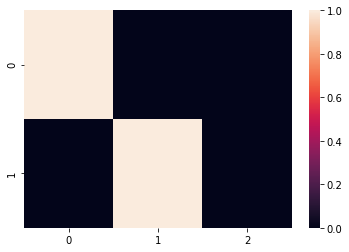

In [103]:
plt.figure();
sn.heatmap(K);
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim(); # get the top and bottom location 
b += 0.5; # Add 0.5 to the bottom
t -= 0.5; # Subtract 0.5 from the top
plt.ylim(b, t); # update the ylim(bottom, top) values

# one-step prediction

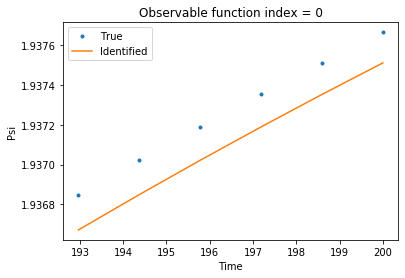

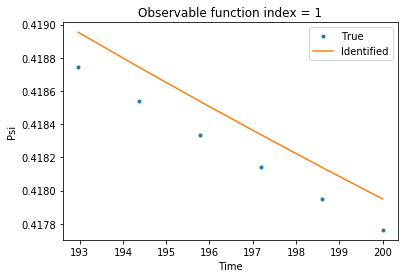

In [104]:
psi_x_p_test = Monomials(data[:,max_train_index+1:data.shape[1]-1],polyorder_x)
psi_x_f_test = Monomials(data[:,max_train_index+2:data.shape[1]],polyorder_x)
psi_u_test = Monomials(uvec*np.ones((numInputs,data[:,max_train_index+1:data.shape[1]-1].shape[1],numTrajectories)),polyorder_u)

traj = 0

psi_x_f_pred = np.dot(K,np.squeeze((np.vstack((psi_x_p_test[:,:,traj],psi_u_test[:,:,traj])))))

numObservables = psi_x_p_test.shape[0] 

obsInd_step = 1;
obsInd_array = np.linspace(0,numObs_x-1,numObs_x)

predSpan = np.linspace(tSpan[max_train_index],tSpan[-1],psi_x_f_pred.shape[1])

for i in obsInd_array:
    obsInd_temp = np.int(i)
    plt.figure()
    plt.plot(predSpan,psi_x_f_test[obsInd_temp,:,traj],'.');
    plt.plot(predSpan,psi_x_f_pred[obsInd_temp,:]);
    plt.gca().legend(('True','Identified'));
    plt.title('Observable function index = ' + str(obsInd_temp))
    plt.xlabel('Time')
    plt.ylabel('Psi')
    plt.grid(False)

# Does the model work for a new initial condition, new input? (does good for a new initial condition with same input. Does bad with new inputs).

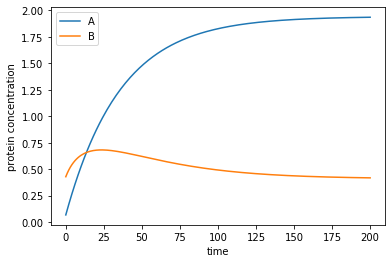

In [105]:
x0 = np.random.uniform(1,0.01,numStates)
# u = np.random.uniform(10,1)

x = odeint(iff_loop,x0,tSpan)
data = x.T

plt.figure();
h = plt.plot(tSpan,data.T);
plt.legend((h[0],h[1]),('A','B'));
plt.xlabel('time');
plt.ylabel('protein concentration');

In [106]:
psi_x_p = Monomials(data[:,0:data.shape[1]-2],polyorder_x)
psi_x_f = Monomials(data[:,1:data.shape[1]-1],polyorder_x)
psi_u = Monomials(u*np.ones((1,data[:,0:data.shape[1]-2].shape[1])),polyorder_u)
psi_xu = Monomials_xu(psi_x_p,psi_u)

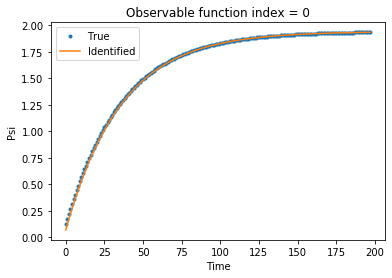

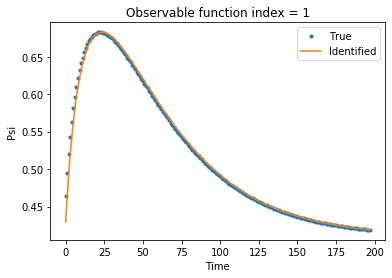

In [110]:
psi_x_f_pred = np.dot(K,np.squeeze((np.vstack((psi_x_p,psi_u)))))

for i in range(0,numObs_x):
    obsInd_temp = np.int(i)
    plt.figure()
    plt.plot(psi_x_f[obsInd_temp,:],'.');
    plt.plot(psi_x_f_pred[obsInd_temp,:]);
    plt.gca().legend(('True','Identified'));
    plt.title('Observable function index = ' + str(obsInd_temp))
    plt.xlabel('Time')
    plt.ylabel('Psi')
    plt.grid(False)
    

# N-step prediction

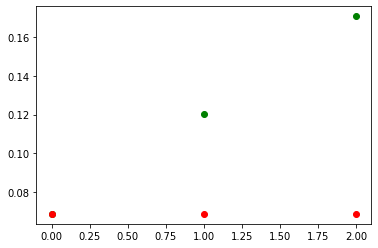

In [112]:
psi_x_p = np.squeeze(Monomials(data[:,0:data.shape[1]-2],polyorder_x),2)
psi_x_f = np.squeeze(Monomials(data[:,1:data.shape[1]-1],polyorder_x),2)
psi_u = np.squeeze(Monomials(u*np.ones((1,data[:,0:data.shape[1]-2].shape[1])),polyorder_u),2)

T = 3
predSpan = np.linspace(0,T-1,T)
obsInd = 0

psi_x_f_pred = psi_x_p[:,0].reshape(len(psi_x_p[:,0]),1)
plt.figure();
for t in range(0,T):
    plt.plot(predSpan[t],psi_x_p[obsInd,t],'o',color='green')
    plt.plot(predSpan[t],psi_x_f_pred[0,:],'o',color='red')
    psi_x_f_pred = np.dot(K,(np.vstack((psi_x_f_pred, psi_u[:,t].reshape(len(psi_u[:,t]),1)))))